<a href="https://colab.research.google.com/github/Romila95/Seq2Seq-NLU/blob/master/Seq2Seq_model_on_ATIS_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SEQ2SEQ MODEL ON NLU**

We implement a Seq2Seq model to acheve Intent Detection (ID) and Slot Filling (SF). The ID model tries to classify a user utterance into an intent, while the SF model tries to ﬁnd what are the “arguments” of such intent.



*Since we require to use the tensorflow contrib module, we use tensorflow version 1.14 instead of v2 which does not support the contrib module anymore*

In [1]:
# pip install tensorflow==1.14
%tensorflow_version 1.14

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.14`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


In [0]:
import tensorflow as tf


In [3]:
import tensorflow.contrib.eager as tfe
tf.enable_eager_execution()

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [0]:
import tensorflow.compat.v1 as tf

In [5]:
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# **Load and Explore Dataset**

The Airline Travel Information System (ATIS) dataset contains data obtained from the Official Airline Guide (OAG, 1990), organized under a relational schema. It contains information about flights, fares, airlines, cities, airports, and ground services, and includes twenty-five supporting tables. The large majority of the questions posed by subjects can be answered from the database with a single relational query.

In [7]:
import os
print(os.listdir("atis"))


['atis.test.query.csv', 'atis.dict.intent.csv', 'atis.train.query.csv', 'atis.train.intent.csv', 'atis.dict.vocab.csv', 'atis.test.pkl', 'atis.test.slots.csv', 'atis.test.intent.csv', 'atis.dict.slots.csv', 'atis.train.slots.csv', 'atis.train.pkl']


In [0]:
import pickle

DATA_DIR="atis"

In [0]:
# load Pickle file 
def load_ds(fname=os.path.join(DATA_DIR,'/atis.train.pkl'), verbose=True):
    with open(fname, 'rb') as stream:
        ds,dicts = pickle.load(stream)
    if verbose:
      print('Done  loading: ', fname)
      print('      samples: {:4d}'.format(len(ds['query'])))
      print('   vocab_size: {:4d}'.format(len(dicts['token_ids'])))
      print('   slot count: {:4d}'.format(len(dicts['slot_ids'])))
      print(' intent count: {:4d}'.format(len(dicts['intent_ids'])))
    return ds,dicts

In [0]:
# convert Pickle file to arrays
def load_atis(filename, add_start_end_token=False, verbose=True):
    train_ds, dicts = load_ds(os.path.join(DATA_DIR,filename), verbose)
    t2i, s2i, in2i = map(dicts.get, ['token_ids', 'slot_ids','intent_ids'])
    i2t, i2s, i2in = map(lambda d: {d[k]:k for k in d.keys()}, [t2i,s2i,in2i])
    query, slots, intent =  map(train_ds.get, ['query', 'slot_labels', 'intent_labels'])

    if add_start_end_token:
        i2s[178] = 'BOS'
        i2s[179] = 'EOS'
        s2i['BOS'] = 178
        s2i['EOS'] = 179

    input_tensor = []
    target_tensor = []
    query_data = []
    intent_data = []
    slot_data = []
    to_show = np.random.randint(0, len(query)-1, 5)
    for i in range(len(query)):
        input_tensor.append(query[i])
        slot_text = []
        slot_vector = []
        for j in range(len(query[i])):
            slot_text.append(i2s[slots[i][j]])
            slot_vector.append(slots[i][j])
        if add_start_end_token:
            slot_text[0] = 'BOS'
            slot_vector[0] = 178
            slot_text[-1] = 'EOS'
            slot_vector[-1]= 179
        target_tensor.append(slot_vector)
        q = ' '.join(map(i2t.get, query[i]))
        query_data.append(q.replace('BOS', '').replace('EOS',''))
        intent_data.append(i2in[intent[i][0]])
        slot = ' '.join(slot_text)
        slot_data.append(slot[1:-1])
        if i in to_show and verbose:
          print('Query text:', q)
          print('Query vector: ', query[i])
          print('Intent label: ', i2in[intent[i][0]])
          print('Slot text: ', slot)
          print('Slot vector: ', slot_vector)
          print('*'*74)
    query_data = np.array(query_data)
    intent_data = np.array(intent_data)
    slot_data = np.array(slot_data)
    intent_data_label = np.array(intent).flatten()
    return t2i, s2i, in2i, i2t, i2s, i2in, input_tensor, target_tensor, query_data, intent_data, intent_data_label, slot_data

# **Loading the Dataset** 

In [11]:
# load ATIS training dataset
t2i_train, s2i_train, in2i_train, i2t_train, i2s_train, i2in_train, \
input_tensor_train, target_tensor_train, \
query_data_train, intent_data_train, intent_data_label_train, slot_data_train = load_atis('atis.train.pkl')

Done  loading:  atis/atis.train.pkl
      samples: 4978
   vocab_size:  943
   slot count:  129
 intent count:   26
Query text: BOS what planes are used by twa EOS
Query vector:  [178 916 686 228 892 277 877 179]
Intent label:  aircraft
Slot text:  O O O O O O B-airline_code O
Slot vector:  [128, 128, 128, 128, 128, 128, 1, 128]
**************************************************************************
Query text: BOS what types of ground transportation are available in philadelphia EOS
Query vector:  [178 916 884 646 457 866 228 244 482 678 179]
Intent label:  ground_service
Slot text:  O O O O O O O O O B-city_name O
Slot vector:  [128, 128, 128, 128, 128, 128, 128, 128, 128, 17, 128]
**************************************************************************
Query text: BOS the most expensive flight between boston and philadelphia EOS
Query vector:  [178 827 608 407 428 259 266 215 678 179]
Intent label:  flight
Slot text:  O O B-cost_relative I-cost_relative O O B-fromloc.city_name 

In [12]:
# load ATIS testing dataset
t2i_test, s2i_test, in2i_test, i2t_test, i2s_test, i2in_test, \
input_tensor_test, target_tensor_test, \
query_data_test, intent_data_test, intent_data_label_test, slot_data_test = load_atis('atis.test.pkl')

Done  loading:  atis/atis.test.pkl
      samples:  893
   vocab_size:  943
   slot count:  129
 intent count:   26
Query text: BOS which flights leave chicago next tuesday and arrive in detroit around 6 pm EOS
Query vector:  [178 920 429 537 297 621 874 215 236 482 361 231 130 689 179]
Intent label:  flight
Slot text:  O O O O B-fromloc.city_name B-depart_date.date_relative B-depart_date.day_name O O O B-toloc.city_name B-arrive_time.time_relative B-arrive_time.time I-arrive_time.time O
Slot vector:  [128, 128, 128, 128, 48, 25, 26, 128, 128, 128, 78, 15, 14, 89, 128]
**************************************************************************
Query text: BOS show me all lufthansa flights from seattle to boston with stopovers in minneapolis EOS
Query vector:  [178 770 581 207 568 429 444 752 851 266 925 799 482 597 179]
Intent label:  flight
Slot text:  O O O O B-airline_name O O B-fromloc.city_name O B-toloc.city_name O O O B-stoploc.city_name O
Slot vector:  [128, 128, 128, 128, 2, 128

# **Check few Samples**

In [13]:
pd.set_option('display.max_colwidth', -1)
df = pd.DataFrame({'query': query_data_train, 'intent': intent_data_train, 'slot filling': slot_data_train})


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


In [14]:
df_small = pd.DataFrame(columns=['query','intent','slot filling'])
j = 0
for i in df.intent.unique():
  df_small.loc[j] = df[df.intent==i].iloc[0]
  j = j+1
  
df_small

,query,intent,slot filling
0,i want to fly from boston at 838 am and arrive in denver at 1110 in the morning,flight,O O O O O B-fromloc.city_name O B-depart_time.time I-depart_time.time O O O B-toloc.city_name O B-arrive_time.time O O B-arrive_time.period_of_day
1,what is the arrival time in san francisco for the 755 am flight leaving washington,flight_time,O O O B-flight_time I-flight_time O B-fromloc.city_name I-fromloc.city_name O O B-depart_time.time I-depart_time.time O O B-fromloc.city_name
2,cheapest airfare from tacoma to orlando,airfare,B-cost_relative O O B-fromloc.city_name O B-toloc.city_name
3,what kind of aircraft is used on a flight from cleveland to dallas,aircraft,O O O O O O O O O O B-fromloc.city_name O B-toloc.city_name
4,what kind of ground transportation is available in denver,ground_service,O O O O O O O O B-city_name
5,what 's the airport at orlando,airport,O O O O O B-city_name
6,which airline serves denver pittsburgh and atlanta,airline,O O O B-fromloc.city_name B-fromloc.city_name O B-fromloc.city_name
7,how far is it from orlando airport to orlando,distance,O O O O O B-fromloc.airport_name I-fromloc.airport_name O B-toloc.city_name
8,what is fare code h,abbreviation,O O O O B-fare_basis_code
9,how much does the limousine service cost within pittsburgh,ground_fare,O O O O B-transport_type O O O B-city_name


For each instance in the intent column, the model is expected to categorize the intent into sections under the labels specified in the slot filling section.

For example, in the first query, "i want to fly from boston at 838 am and arrive in denver at 1110 in the morning", the model should correctly label the entities needed to fulfill user’s goal in its intention to take a flight. These are “boston” as departure city (B-fromloc.city), “8:38 am” as departure time (B-depart_time.time), “denver” as destination city (B-toloc.city_name), “11:10” as arrival time (B-arrive_time.time) and “morning” as arrival period of day (B-arrive_time.period_of_day).

Some of the labels are displayed below.

In [15]:
i2s_train_values = list(i2s_train.values())
df3 = pd.DataFrame()
for i in range(7):
  df3[str(i)] = i2s_train_values[i*15:(i+1)*15]
df3

,0,1,2,3,4,5,6
0,B-aircraft_code,B-arrive_time.time_relative,B-depart_date.year,B-flight_time,B-return_date.day_name,B-today_relative,I-arrive_time.time_relative
1,B-airline_code,B-booking_class,B-depart_time.end_time,B-fromloc.airport_code,B-return_date.day_number,B-toloc.airport_code,I-city_name
2,B-airline_name,B-city_name,B-depart_time.period_mod,B-fromloc.airport_name,B-return_date.month_name,B-toloc.airport_name,I-class_type
3,B-airport_code,B-class_type,B-depart_time.period_of_day,B-fromloc.city_name,B-return_date.today_relative,B-toloc.city_name,I-cost_relative
4,B-airport_name,B-compartment,B-depart_time.start_time,B-fromloc.state_code,B-return_time.period_mod,B-toloc.country_name,I-depart_date.day_name
5,B-arrive_date.date_relative,B-connect,B-depart_time.time,B-fromloc.state_name,B-return_time.period_of_day,B-toloc.state_code,I-depart_date.day_number
6,B-arrive_date.day_name,B-cost_relative,B-depart_time.time_relative,B-meal,B-round_trip,B-toloc.state_name,I-depart_date.today_relative
7,B-arrive_date.day_number,B-day_name,B-economy,B-meal_code,B-state_code,B-transport_type,I-depart_time.end_time
8,B-arrive_date.month_name,B-day_number,B-fare_amount,B-meal_description,B-state_name,I-airline_name,I-depart_time.period_of_day
9,B-arrive_date.today_relative,B-days_code,B-fare_basis_code,B-mod,B-stoploc.airport_code,I-airport_name,I-depart_time.start_time


# ** Creating Tensors**

The query and slot filling vectors are padded to ax length for building tensors. Two sensors are provided for target, one is teacher tensor, which forces the decoder to follow a correct output slot and the other is the true target tensor, which defines what the decoder should output given the teacher tensor. 


In [0]:
def max_length(tensor):
    return max(len(t) for t in tensor)

# Helper function to pad the query tensor and slot (target) tensor to the same length. 
# Also creates a tensor for teacher forcing.
def create_tensors(input_tensor, target_tensor, nb_sample=9999999, max_len=0):
    len_input, len_target  = max_length(input_tensor), max_length(target_tensor)
    len_input = max(len_input,max_len)
    len_target = max(len_target,max_len)
    

    # Padding the input and output tensor to the maximum length
    input_data = tf.keras.preprocessing.sequence.pad_sequences(input_tensor, 
                                                                 maxlen=len_input,
                                                                 padding='post')

    teacher_data = tf.keras.preprocessing.sequence.pad_sequences(target_tensor, 
                                                                  maxlen=len_target , 
                                                                  padding='post')
    
    target_data = [[teacher_data[n][i+1] for i in range(len(teacher_data[n])-1)] for n in range(len(teacher_data))]
    target_data = tf.keras.preprocessing.sequence.pad_sequences(target_data, maxlen=len_target, padding="post")
    target_data = target_data.reshape((target_data.shape[0], target_data.shape[1], 1))
    
    nb = len(input_data)
    p = np.random.permutation(nb)
    input_data = input_data[p]
    teacher_data = teacher_data[p]
    target_data = target_data[p]

    return input_data[:min(nb_sample, nb)], teacher_data[:min(nb_sample, nb)], target_data[:min(nb_sample, nb)], len_input, len_target 
           
input_data_train, teacher_data_train, target_data_train, \
                  len_input_train, len_target_train  = create_tensors(input_tensor_train, target_tensor_train)
input_data_test, teacher_data_test, target_data_test, \
                 len_input_test, len_target_test  = create_tensors(input_tensor_test, target_tensor_test, max_len=len_input_train)

Train and test vocabularies are combined to compute vocabulary size. 

In [17]:
def get_vocab_size(t2i_train, t2i_test, s2i_train, s2i_test):
    vocab_in_size = len({**t2i_train, **t2i_test})
    vocab_out_size = len({**s2i_train, **s2i_test})
    return vocab_in_size, vocab_out_size
  
vocab_in_size, vocab_out_size = get_vocab_size(t2i_train, t2i_test, s2i_train, s2i_test)
vocab_in_size, vocab_out_size

(943, 129)

# **Seq2Seq Model for Slot Filling**

The model is created using a LSTM in the encoder and decoder. The input goes through an encoder model which gives the encoder output of shape (batch_size, max_length, hidden_size) and the encoder hidden state of shape (batch_size, hidden_size). Both encoder and decoders use an Embedding layer to project the sentences to learn a meaningful representation of the user query, which is fed to a unidirectional LSTM layer with 1024 cells.

In [18]:
from keras.layers import Input, Embedding, Dense, Dropout, LSTM
from keras.models import Model

Using TensorFlow backend.


In [0]:
# tf.reset_default_graph()

In [20]:
BUFFER_SIZE = len(input_data_train)
BATCH_SIZE = 64
N_BATCH = BUFFER_SIZE//BATCH_SIZE
embedding_dim = 256
units = 1024

# Create the Encoder layers first.
encoder_inputs = Input(shape=(len_input_train,))
encoder_emb = Embedding(input_dim=vocab_in_size, output_dim=embedding_dim)
encoder_lstm = LSTM(units=units, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_emb(encoder_inputs))
encoder_states = [state_h, state_c]

# Now create the Decoder layers.
decoder_inputs = Input(shape=(None,))
decoder_emb = Embedding(input_dim=vocab_out_size, output_dim=embedding_dim)
decoder_lstm = LSTM(units=units, return_sequences=True, return_state=True)
decoder_lstm_out, _, _ = decoder_lstm(decoder_emb(decoder_inputs), initial_state=encoder_states)
# Two dense layers to improve inference capabilities.
decoder_d1 = Dense(units, activation="relu")
decoder_d2 = Dense(vocab_out_size, activation="softmax")
# Drop-out is added in the dense layers to help mitigate overfitting in this part of the model.
decoder_out = decoder_d2(Dropout(rate=.4)(decoder_d1(Dropout(rate=.4)(decoder_lstm_out))))

# Finally, create a training model which combines the encoder and the decoder.
# Note that this model has three inputs:
#  encoder_inputs=[batch,encoded_words] from input (query)
#  decoder_inputs=[batch,encoded_words] from output (slots). This is the "teacher tensor".
#  decoder_out=[batch,encoded_words] from output (slots). This is the "target tensor".
model = Model([encoder_inputs, decoder_inputs], decoder_out)
# Use sparse_categorical_crossentropy so we don't have to expand decoder_out into a massive one-hot array.
model.compile(optimizer=tf.train.AdamOptimizer(), loss="sparse_categorical_crossentropy", metrics=['sparse_categorical_accuracy'])

model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 48)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 48, 256)      241408      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 256)    33024       input_2[0][0]                    
___________

**Training the Seq2Seq Model**

Since our target vectors are not one-hot encoded, we use sparse categorical crossentropy as loss function. With Adam as optimizer in 50 epochs, we use 3982 training samples, and 996 validation samples.

In [0]:
#import torch

#device = torch.device("cpu")

In [0]:
#from tensorflow.contrib.rnn import *

In [23]:
epochs = 50
history = model.fit([input_data_train, teacher_data_train], target_data_train,batch_size=BATCH_SIZE,epochs=epochs,validation_data=([input_data_test, teacher_data_test], target_data_test))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 4978 samples, validate on 893 samples
Epoch 1/50
4978/4978 [==============================] - 613s 123ms/step - loss: 0.8951 - sparse_categorical_accuracy: 0.8539 - val_loss: 0.5356 - val_sparse_categorical_accuracy: 0.8906
Epoch 2/50
4978/4978 [==============================] - 612s 123ms/step - loss: 0.4409 - sparse_categorical_accuracy: 0.8975 - val_loss: 0.3634 - val_sparse_categorical_accuracy: 0.9171
Epoch 3/50
4978/4978 [==============================] - 617s 124ms/step - loss: 0.3441 - sparse_categorical_accuracy: 0.9176 - val_loss: 0.3049 - val_sparse_categorical_accuracy: 0.9235
Epoch 4/50
4978/4978 [==============================] - 647s 130ms/step - loss: 0.3087 - sparse_categorical_accuracy: 0.9229 - val_loss: 0.2842 - val_sparse_categorical_accuracy: 0.9288
Epoch 5/50
4978/4978 [==============================] - 644s 129ms/step - loss: 0.2908 - sparse_categorical_accu

In [0]:
import matplotlib.pyplot as plt

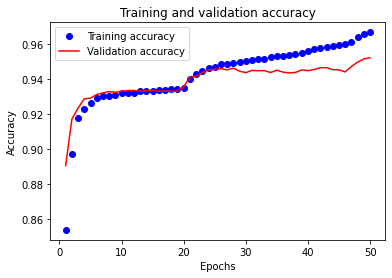

In [25]:
def plot_training_accuracy(history):

  acc = history.history['sparse_categorical_accuracy']
  val_acc = history.history['val_sparse_categorical_accuracy']

  epochs = range(1, len(acc) + 1)

  plt.plot(epochs, acc, 'bo', label='Training accuracy')
  plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.show()
  
plot_training_accuracy(history)

# **Accuracies**

We find 98% accuracy on the training data and a validation accuracy just below 96%. The validation accuracy is optimum around epoch 45 and starts to overfit beyond that level.

#**Inference**

Prediction will require two separate models from training. We need to break up the encoder and decoder mechanisms. We then run the entire input sequence through the encoder, then create the output by predicting with the decoder one step at a time.

In [26]:
# Create the encoder model from the tensors we previously declared.
encoder_model = Model(encoder_inputs, [encoder_outputs, state_h, state_c])

# Generate a new set of tensors for our new inference decoder. Note that we are using new tensors, 
# this does not preclude using the same underlying layers that we trained on. (e.g. weights/biases).
inf_decoder_inputs = Input(shape=(None,), name="inf_decoder_inputs")
# We'll need to force feed the two state variables into the decoder each step.
state_input_h = Input(shape=(units,), name="state_input_h")
state_input_c = Input(shape=(units,), name="state_input_c")
decoder_res, decoder_h, decoder_c = decoder_lstm(
    decoder_emb(inf_decoder_inputs), 
    initial_state=[state_input_h, state_input_c])
inf_decoder_out = decoder_d2(decoder_d1(decoder_res))
inf_model = Model(inputs=[inf_decoder_inputs, state_input_h, state_input_c], 
                  outputs=[inf_decoder_out, decoder_h, decoder_c])
                  
def preprocess_query(w):
    w = w.rstrip().strip().lower()
    w = "BOS " + w + " EOS"
    return w
  
# Converts the given query (just a string) into a vector of word IDs
# using the language specified. This can be used for either the input (query)
# or target (slot)
# Output is 1-D: [timesteps/words]
def query_to_vector(query, len_input=len_input_train, t2i=t2i_train):
    pre = preprocess_query(query)
    vec = np.zeros(len_input)
    query_list = [t2i[s] for s in pre.split(' ')]
    for i,w in enumerate(query_list):
        vec[i] = w
    return vec

# Given an input string, an encoder model (infenc_model) and a decoder model (infmodel),
# return a predicted slot string.
def predict_slots(input_query, infenc_model, infmodel, 
                  len_input=len_input_train, 
                  t2i=t2i_train, s2i=s2i_train, i2s=i2s_train,
                  len_target=len_target_train,
                  attention=False):
    sent_len = len(input_query.split())
    sv = query_to_vector(input_query, len_input, t2i)
    # Reshape so we can use the encoder model. New shape=[samples,sequence length]
    sv = sv.reshape(1,len(sv))
    [emb_out, sh, sc] = infenc_model.predict(x=sv)
    
    i = 0
    start_vec = s2i["O"]
    stop_vec = s2i["O"]
    # We will continuously feed cur_vec as an input into the decoder to produce the next word,
    # which will be assigned to cur_vec. Start it with "EOS".
    cur_vec = np.zeros((1,1))
    cur_vec[0,0] = start_vec
    cur_word = "BOS"
    output_query = ""
    # Start doing the feeding. Terminate when the model predicts an "EOS" or we reach the end
    # of the max target slot length.
    while cur_word != "EOS" and i < (len_target-1) and i < sent_len+1:
        i += 1
        if cur_word != "BOS":
            output_query = output_query + " " + cur_word
        x_in = [cur_vec, sh, sc]
        # This will allow us to accomodate attention models, which we will talk about later.
        if attention:
            x_in += [emb_out]
        [nvec, sh, sc] = infmodel.predict(x=x_in)
        # The output of the model is a massive softmax vector with one spot for every possible word. Convert
        # it to a word ID using argmax().
        cur_vec[0,0] = np.argmax(nvec[0,0])
        cur_word = i2s[np.argmax(nvec[0,0])]
    return output_query
    
input_query = "what is the cheapest flight from boston to san francisco"
print(predict_slots(input_query, encoder_model, inf_model))


 O O O B-cost_relative O O B-fromloc.city_name O B-toloc.city_name O


In [0]:
from nltk.translate.bleu_score import corpus_bleu

In [30]:
def evaluate_slot_filling(queries, true_slots,
                          len_input=len_input_test, 
                          t2i=t2i_test, s2i=s2i_test, i2s=i2s_test,
                          len_target=len_target_test):
  predicted_slots = []
  for q in queries:
    s = predict_slots(q, encoder_model, inf_model,
                      len_input, 
                      t2i, s2i, i2s,
                      len_target)
    predicted_slots.append(s)
  # calculate BLEU score
  print('BLEU-1: %f' % corpus_bleu(true_slots, predicted_slots, weights=(1.0, 0, 0, 0)))
  print('BLEU-2: %f' % corpus_bleu(true_slots, predicted_slots, weights=(0.5, 0.5, 0, 0)))
  print('BLEU-3: %f' % corpus_bleu(true_slots, predicted_slots, weights=(0.3, 0.3, 0.3, 0)))
  print('BLEU-4: %f' % corpus_bleu(true_slots, predicted_slots, weights=(0.25, 0.25, 0.25, 0.25)))
  
evaluate_slot_filling(query_data_test, slot_data_test)

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


BLEU-1: 0.231750
BLEU-2: 0.481404
BLEU-3: 0.644920
BLEU-4: 0.693833


The model performs best with a BLEU of 69.4% when comparing between 4-grams of predicted and true slots followed by a BLEU of 64.5% for 3-grams.